In [5]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pyDOE import lhs

np.random.seed(1234)

In [2]:
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.current_device())  # Should return an integer (GPU index)
print(torch.cuda.get_device_name(torch.cuda.current_device()))  # GPU name

True
0
NVIDIA GeForce GTX 1650


In [3]:
# CUDA support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

print(f"Using device: {device}")

torch.backends.cudnn.benchmark = True

Using device: cuda


In [4]:
class DNN(nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        modules = []
        for i in range(len(layers) - 2):  # Exclude last layer for activation
            modules.append(nn.Linear(layers[i], layers[i+1]))
            modules.append(nn.Tanh())
        modules.append(nn.Linear(layers[-2], layers[-1]))  # Last layer (no activation)
        self.network = nn.Sequential(*modules)

        for layer in self.network:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)

    def forward(self, x):
        return self.network(x)

In [5]:
lbfgs_lr = 0.0005
adam_lr = 0.001

In [6]:
class PINN():
    def __init__(self, X, Y, layers, nu):
        self.x_dom = torch.tensor(X['dom'], requires_grad=True).float().to(device).view(-1, 1)
        self.y_dom = torch.tensor(Y['dom'], requires_grad=True).float().to(device).view(-1, 1)

        self.x_left = torch.tensor(X['left'], requires_grad=True).float().to(device).view(-1, 1)
        self.y_left = torch.tensor(Y['left'], requires_grad=True).float().to(device).view(-1, 1)
        
        self.x_top = torch.tensor(X['top'], requires_grad=True).float().to(device).view(-1, 1)
        self.y_top = torch.tensor(Y['top'], requires_grad=True).float().to(device).view(-1, 1)

        self.x_right = torch.tensor(X['right'], requires_grad=True).float().to(device).view(-1, 1)
        self.y_right = torch.tensor(Y['right'], requires_grad=True).float().to(device).view(-1, 1)

        self.x_down = torch.tensor(X['down'], requires_grad=True).float().to(device).view(-1, 1)
        self.y_down = torch.tensor(Y['down'], requires_grad=True).float().to(device).view(-1, 1)

        self.nu = nu

        self.w_pde = 1
        self.w_bc = 1

        # DNN
        self.dnn = DNN(layers).to(device)

        # Optimizer
        self.optimizer_lbfgs = torch.optim.LBFGS(
            self.dnn.parameters(),
            lr=lbfgs_lr,
            max_iter=50000,
            max_eval=50000,
            history_size=50,
            tolerance_grad=1e-5,
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"
        )

        self.optimizer_adam = torch.optim.Adam(self.dnn.parameters(), lr=adam_lr)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer_adam, step_size=2000, gamma=0.5)
        self.iter = 0

    def model_value(self, x, y):
        out = self.dnn(torch.cat((x, y), dim=1))
        u = out[:,0].view(-1, 1)
        v = out[:,1].view(-1, 1)
        sxx = out[:,2].view(-1, 1)
        syy = out[:,3].view(-1, 1)
        sxy = out[:,4].view(-1, 1)
        return u, v, sxx, syy, sxy

    def pde_loss(self, x, y):
        u, v, sxx, syy, sxy = self.model_value(x, y)

        dx_u = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
        dy_u = torch.autograd.grad(u, y, torch.ones_like(u), create_graph=True)[0]
        dx_v = torch.autograd.grad(v, x, torch.ones_like(v), create_graph=True)[0]
        dy_v = torch.autograd.grad(v, y, torch.ones_like(v), create_graph=True)[0]

        dx_sxx = torch.autograd.grad(sxx, x, torch.ones_like(sxx), create_graph=True)[0]
        dy_syy = torch.autograd.grad(syy, y, torch.ones_like(syy), create_graph=True)[0]
        dy_sxy = torch.autograd.grad(sxy, y, torch.ones_like(sxy), create_graph=True)[0]
        dx_sxy = torch.autograd.grad(sxy, x, torch.ones_like(sxy), create_graph=True)[0]

        term_xx = 1 / (1 - self.nu**2) * (dx_u + self.nu*dy_v)
        term_yy = 1 / (1 - self.nu**2) * (dy_v + self.nu*dx_u)
        term_xy = 1 / (2*(1 + self.nu)) * (dy_u + dx_v)

        r1 = torch.mean(torch.pow((sxx - term_xx), 2))
        r2 = torch.mean(torch.pow((syy - term_yy), 2))
        r3 = torch.mean(torch.pow((sxy - term_xy), 2))
        r4 = torch.mean(torch.pow((dx_sxx + dy_sxy), 2))
        r5 = torch.mean(torch.pow((dy_syy + dx_sxy), 2))

        residual = r1 + r2+ r3 + r4 + r5
        return residual

    def bc_loss(self, xl, yl, xt, yt, xr, yr, xd, yd):
        u_l, v_l, _, _, _ = self.model_value(xl, yl)
        _, _, _, syy_t, sxy_t = self.model_value(xt, yt)
        _, _, sxx_r, _, sxy_r = self.model_value(xr, yr)
        _, _, _, syy_d, sxy_d = self.model_value(xd, yd)

        b = torch.mean(torch.pow(u_l, 2))
        b += torch.mean(torch.pow(v_l, 2))

        b += torch.mean(torch.pow(syy_t, 2))
        b += torch.mean(torch.pow(sxy_t, 2))

        b += torch.mean(torch.pow(sxx_r - 1, 2))
        b += torch.mean(torch.pow(sxy_r, 2))

        b += torch.mean(torch.pow(syy_d, 2))
        b += torch.mean(torch.pow(sxy_d, 2))
        return b

    
    def loss_func(self):
        pde = self.pde_loss(self.x_dom, self.y_dom)
        bc = self.bc_loss(self.x_left, self.y_left, self.x_top, self.y_top, self.x_right, self.y_right, self.x_down, self.y_down)

        return pde, bc


    def lbfgs_func(self):
        pde_loss, bc_loss = self.loss_func()
        loss = self.w_pde*pde_loss + self.w_bc*bc_loss
        self.optimizer_lbfgs.zero_grad()
        loss.backward()

        if self.iter % 100 == 0:
            print(f"Iter: {self.iter}, Loss: {'{:e}'.format(loss.item())}")
        self.iter += 1
        return loss
    
    def train(self, epochs=1000):
        self.dnn.train()
        for epoch in range(epochs):
            pde_loss, bc_loss = self.loss_func()
            loss = self.w_pde*pde_loss + self.w_bc*bc_loss

            self.optimizer_adam.zero_grad()
            loss.backward()
            self.optimizer_adam.step()
            self.scheduler.step()

            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {'{:e}'.format(loss.item())}")
                print(f"PDE: {'{:e}'.format(pde_loss.item())}, BC: {'{:e}'.format(bc_loss.item())}")
        self.optimizer_lbfgs.step(self.lbfgs_func)

    def predict(self, x, y):
        x = torch.tensor(x).float().to(device)
        y = torch.tensor(y).float().to(device)

        self.dnn.eval()
        u, v, sxx, syy, sxy = self.model_value(x, y)
        u = u.detach().cpu().numpy()
        v = v.detach().cpu().numpy()
        sxx = sxx.detach().cpu().numpy()
        syy = syy.detach().cpu().numpy()
        sxy = sxy.detach().cpu().numpy()
        return u, v, sxx, syy, sxy

In [7]:
def generate_points(points, l, h):
    pd = points[0]
    pb = points[1]

    dom = lhs(2, pd)
    dom_x = dom[:,0] * l
    dom_y = dom[:,1] * h

    left_x = np.zeros(pb)
    left_y = lhs(1, pb) * h

    top_x = lhs(1, pb) * l
    top_y = np.ones(pb) * h

    right_x = np.ones(pb) * l
    right_y = lhs(1, pb) * h

    down_x = lhs(1, pb) * l
    down_y = np.zeros(pb)

    X = {'dom': dom_x, 'left': left_x, 'top': top_x, 'right': right_x, 'down': down_x}
    Y = {'dom': dom_y, 'left': left_y, 'top': top_y, 'right': right_y, 'down': down_y}
    return X, Y

In [9]:
points = [1000, 50]
l = 1
h = 1
X, Y = generate_points(points, l, h)

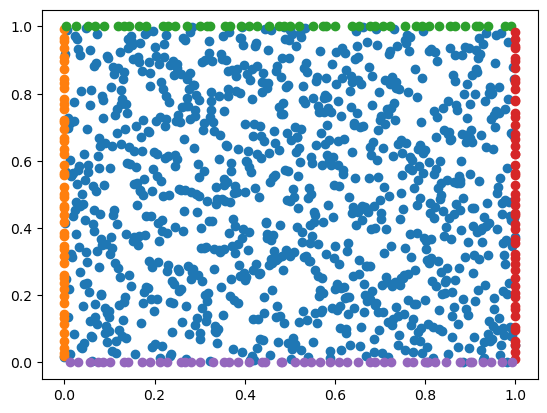

In [10]:
plt.scatter(X['dom'], Y['dom'])
plt.scatter(X['left'], Y['left'])
plt.scatter(X['top'], Y['top'])
plt.scatter(X['right'], Y['right'])
plt.scatter(X['down'], Y['down'])

In [12]:
p = [1000, 50]
l = 1
h = 1
nu = 0.3

X, Y = generate_points(p, l, h)


nodes = 64
layers = [2] + 7 * [nodes] + [5]

In [13]:
model = PINN(X, Y, layers, nu)

In [14]:
model.train(4000)

Epoch 0, Loss: 1.258561e+00
PDE: 3.651718e-01, BC: 8.933892e-01
Epoch 100, Loss: 9.249962e-03
PDE: 2.839209e-03, BC: 6.410752e-03
Epoch 200, Loss: 7.018601e-03
PDE: 1.203255e-03, BC: 5.815346e-03
Epoch 300, Loss: 6.249232e-03
PDE: 1.014501e-03, BC: 5.234730e-03
Epoch 400, Loss: 5.604709e-03
PDE: 1.039995e-03, BC: 4.564713e-03
Epoch 500, Loss: 5.104078e-03
PDE: 1.108613e-03, BC: 3.995466e-03
Epoch 600, Loss: 5.533065e-03
PDE: 1.428569e-03, BC: 4.104496e-03
Epoch 700, Loss: 4.769244e-03
PDE: 1.183241e-03, BC: 3.586003e-03
Epoch 800, Loss: 4.675001e-03
PDE: 1.185084e-03, BC: 3.489917e-03
Epoch 900, Loss: 7.224395e-03
PDE: 2.750227e-03, BC: 4.474169e-03
Epoch 1000, Loss: 4.525359e-03
PDE: 1.162579e-03, BC: 3.362780e-03
Epoch 1100, Loss: 4.412076e-03
PDE: 1.161107e-03, BC: 3.250969e-03
Epoch 1200, Loss: 1.394155e-02
PDE: 7.280585e-03, BC: 6.660969e-03
Epoch 1300, Loss: 4.222409e-03
PDE: 1.150882e-03, BC: 3.071527e-03
Epoch 1400, Loss: 4.068418e-03
PDE: 1.158175e-03, BC: 2.910242e-03
Epoch 1

In [6]:
L = 1  # Length of the sheet
H = 1   # Height of the sheet
nx, ny = 10, 10  # Number of grid points in x and y
E = 7e10  # Young's modulus (Pa)
nu = 0.3   # Poisson's ratio
sigma_0 = 500e6  # Applied stress (Pa)

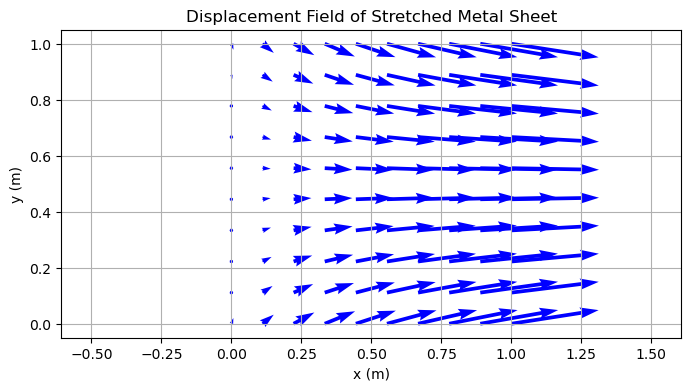

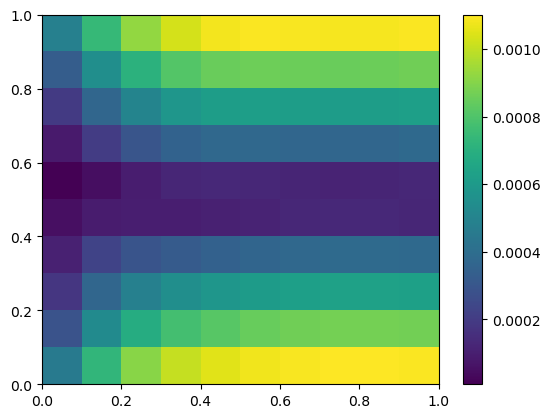

In [22]:
x = np.linspace(0, 1, 10)
y = np.linspace(0, 1, 10)
X, Y = np.meshgrid(x, y)

x_flat = X.flatten().reshape(-1, 1)  
y_flat = Y.flatten().reshape(-1, 1)

u, v, sxx, syy, sxy = model.predict(x_flat, y_flat)

U = sigma_0 / E

u = u*U
v = v*U
sxx = sxx*sigma_0
syy = syy*sigma_0
sxy = sxy*sigma_0


u = u.reshape(10, 10)
v = v.reshape(10, 10)
sx = sxx.reshape(10, 10)
sy = syy.reshape(10, 10)

plt.figure(figsize=(8, 4))
plt.quiver(X, Y, u, v, scale=0.05, color="b")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("Displacement Field of Stretched Metal Sheet")
plt.axis("equal")
plt.grid(True)
plt.show()

plt.figure()
plt.imshow(np.abs(v), extent=[0, 1, 0, 1], origin="lower", aspect="auto")
plt.colorbar()
plt.show()


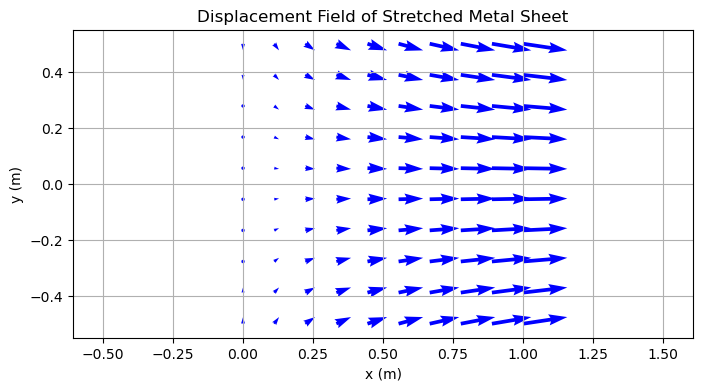

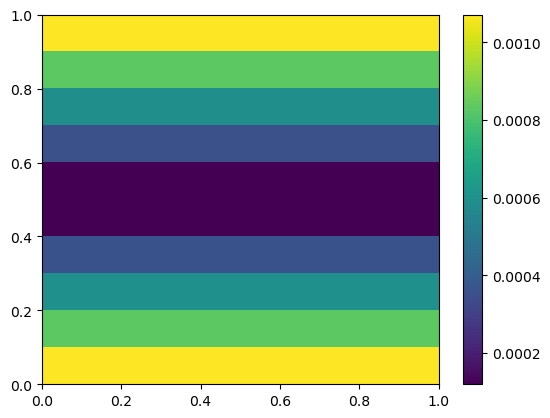

In [7]:

# Generate grid points
x = np.linspace(0, L, nx)
y = np.linspace(-H/2, H/2, ny)
X, Y = np.meshgrid(x, y)

# Compute displacement field
u = (sigma_0 / E) * X  # Displacement in x-direction
v = -nu * (sigma_0 / E) * Y  # Displacement in y-direction

# Plot displacement field
plt.figure(figsize=(8, 4))
plt.quiver(X, Y, u, v, scale=0.1, color="b")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("Displacement Field of Stretched Metal Sheet")
plt.axis("equal")
plt.grid(True)
plt.show()

plt.figure()
plt.imshow(np.abs(v), extent=[0, 1, 0, 1], origin="lower", aspect="auto")
plt.colorbar()
plt.show()
